# Clasificador Muiltietiqueta
En este notebook vamos a utilizar varios métodos de ML y DL para entrenar un modelo clasificador multietiqueta para analizar una serie de tuits etiquetados con el sentimiento o sentimientos que expresan (análisis del sentimiento). Los posibles sentimientos son: <i>ira, expectación, indignación, miedo, alegría, amor, optimismo, pesimismo, tristeza, sorpresa y confianza</i>.

## Adquisición y limpieza del texto

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

# Leemos los datos
df_train = pd.read_csv('sem_eval_train_es.csv', index_col=None, encoding = "utf-8")
df_test = pd.read_csv('sem_eval_test_blank_es.csv', index_col=None, encoding = "utf-8")

In [2]:
df_train.sample(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
2126,2018-Es-03993,@AngeldebritoOk Por favor que cosa horrible,False,False,True,False,False,False,False,False,False,False,False
193,2018-Es-05862,"Depresión rima con Bennington, coincidencia? No lo creo.",False,False,False,False,False,False,False,False,True,False,False
1953,2018-Es-00602,"También se antoja que me haga suya la dvd, pero ese ya es otro asunto 😊",False,True,False,False,True,False,False,False,False,False,False
3209,2018-Es-00868,"Los efectos en star wars me encantan, es genial ver cómo se esforzaban antes para que todo pareciera real.",False,False,False,False,True,False,True,False,False,False,False
2071,2018-Es-01016,"@pajeranger Ay si, automaticamente al leer el mensaje más frívolo del mundo algún depresivo seguro se salva jajaja",False,False,False,False,True,False,False,False,False,False,False


In [3]:
df_test.sample(5)

,ID,Tweet
461,2018-Es-00648,Habíamos peleando con Andrea y me dice para tomar Fernet y se me pasó el enojo Jejee (amordehermanas)♥♥♥
469,2018-Es-05136,@josephsvocals en mi escuela lo hicieron y las profesoras hicieron un drama y los encerraron todo el recreo para hablarles de dios
150,2018-Es-00899,"Lo sé, soy hermosa!: me siento genial"
40,2018-Es-05188,"Si como amiga me seguía los caprichos no me imagino que pasará ahora, próximamente termino tinturado"
222,2018-Es-03829,"Lo llame a mi novio que dormía, solamente para cagarme de risa dos hs"


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3561 entries, 0 to 3560
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            3561 non-null   object
 1   Tweet         3561 non-null   object
 2   anger         3561 non-null   bool  
 3   anticipation  3561 non-null   bool  
 4   disgust       3561 non-null   bool  
 5   fear          3561 non-null   bool  
 6   joy           3561 non-null   bool  
 7   love          3561 non-null   bool  
 8   optimism      3561 non-null   bool  
 9   pessimism     3561 non-null   bool  
 10  sadness       3561 non-null   bool  
 11  surprise      3561 non-null   bool  
 12  trust         3561 non-null   bool  
dtypes: bool(11), object(2)
memory usage: 94.0+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      679 non-null    object
 1   Tweet   679 non-null    object
dtypes: object(2)
memory usage: 10.7+ KB


Tras explorar los datos, hemos detectado que existen tuits que no han sido etiquetados, por lo tanto, llevamos a cabo una limpieza de datos para descartar aquellos tuits que no tengan etiqueta o simplemente filas que ni siquiera contengan tuits.

In [6]:
df_train_clean = df_train.dropna()

In [7]:
df_test_clean = df_test.dropna()

Creamos una nueva columna con la longitud de cada tweet para seguir explorando nuestros datos, esta vez enfocando la atención en el texto.

In [8]:
df_train_clean['pre_clean_len'] = df_train_clean.Tweet.str.len()

In [9]:
df_train_clean.pre_clean_len.describe()

count    3561.000000
mean       77.048301
std        35.753085
min         9.000000
25%        47.000000
50%        73.000000
75%       106.000000
max       140.000000
Name: pre_clean_len, dtype: float64

Lo representamos como diagrama de cajas:

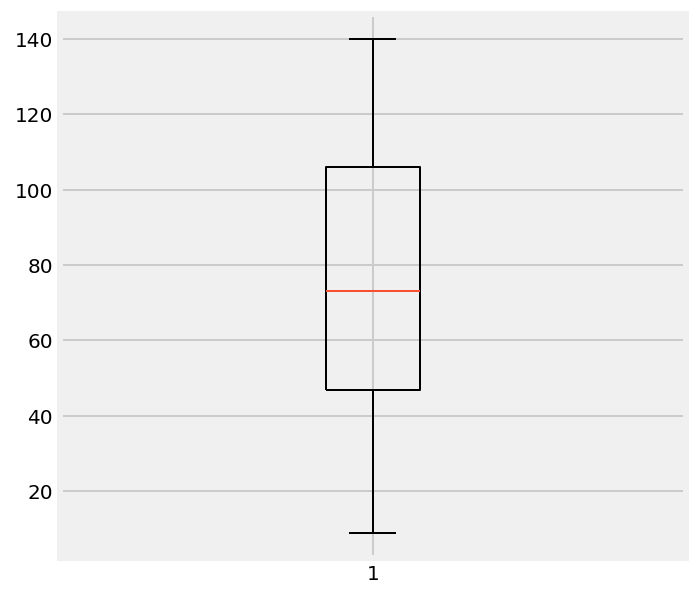

In [10]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_train_clean.pre_clean_len)
plt.show()

## Limpieza y preprocesado de texto
A continuación iniciamos la limpieza y pre-procesado de la columna 'Tweet', la cual contiene los documentos con los que vamos a trabajar.<br>
Hacemos un pequeño pre-procesado del texto antes de extraer las características:  
- Quitamos las menciones y las URL del texto porque no aportan valor para el análisis de sentimientos.
- Los hashtag sí que pueden aportar valor así que simplemente quitamos el #.
- Quitamos los signos de puntuación y palabras menores de 3 caracteres.
- Por último quitamos todos los símbolos de puntuación del texto (que forman parte de un token).
- Lematizamos el texto y lo guardamos en otra columna para comparar resultados del clasificador. 

Para llevar a cabo este proceso hacemos uso de la librería Spacy y de las posibilidades que nos ofrece el conjunto de expresiones regulares.

In [11]:
import re, string, spacy
nlp=spacy.load('es_core_news_md')

In [12]:
doc = nlp(df_train_clean.Tweet[15])
type(doc)

spacy.tokens.doc.Doc

In [13]:
doc

@wichouya Que diosito te escuche jaja 

In [14]:
text = re.sub(r'@[\w_]+', 'MENCION', df_train_clean.Tweet[15])
text = re.sub(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', 'URL', text)
text

'MENCION Que diosito te escuche jaja '

In [15]:
#lista de stop-words específicos de nuestro corpus (aproximación)
stop_words = ['unos', 'unas', 'algún', 'alguna', 'algunos', 'algunas', 'ese', 'eso', 'así']

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+', 'MENCION', text) #elimina menciones y URL
    text = re.sub(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', 'URL', text) #elimina menciones y URL

    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens if not (tok in stop_words) and len(tok)>2]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text
    

Probamos el funcionamiento de estas funciones sobre un tweet de ejemplo:

In [16]:
print('Original:\n',df_train_clean.Tweet[15])
print('\nLimpiado:\n',clean_text(df_train_clean.Tweet[15]))
print('\nLematizado:\n',clean_text(df_train_clean.Tweet[15], lemas=True))

Original:
 @wichouya Que diosito te escuche jaja 

Limpiado:
 mencion que diosito escuche jaja

Lematizado:
 mencion que diosito escuchar jajo


Aplicamos la clase que limpia el texto (<i>clean_text</i>) a todos los tuits de nuestro dataset y creamos una columna nueva con el texto lematizado

In [17]:
df_train_clean["limpio"]=df_train_clean['Tweet'].apply(clean_text, lemas=True)

Descartamos los tuits que se han quedado vacíos tras la limpieza

In [18]:
df_train_clean=df_train_clean[df_train_clean["limpio"]!='']

In [19]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3560
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             3561 non-null   object
 1   Tweet          3561 non-null   object
 2   anger          3561 non-null   bool  
 3   anticipation   3561 non-null   bool  
 4   disgust        3561 non-null   bool  
 5   fear           3561 non-null   bool  
 6   joy            3561 non-null   bool  
 7   love           3561 non-null   bool  
 8   optimism       3561 non-null   bool  
 9   pessimism      3561 non-null   bool  
 10  sadness        3561 non-null   bool  
 11  surprise       3561 non-null   bool  
 12  trust          3561 non-null   bool  
 13  pre_clean_len  3561 non-null   int64 
 14  limpio         3561 non-null   object
dtypes: bool(11), int64(1), object(3)
memory usage: 177.4+ KB


In [20]:
df_train_clean.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,pre_clean_len,limpio
0,2018-Es-01643,"@aliciaenp Ajajjaa somos del clan twitteras perdidas pa eventos ""importantes""",False,False,False,False,True,False,False,False,False,False,False,78,mencion ajajjaa ser del clan twittera perdido evento importante
1,2018-Es-05142,@AwadaNai la mala suerte del gato fichame la cara de help me pls,False,False,False,True,False,False,False,True,False,False,False,64,mencion malo suerte del gato fichame cara help pls
2,2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. Especialmente por tratarse de él. No hay justificación.,True,False,False,False,False,False,False,False,False,False,False,100,mencion tampoco agradar mucho especialmente por tratar él haber justificación
3,2018-Es-00208,"Para llevar a los bebes de un lugar a otro debemos cantarles canciones... Quiero cantarles Gunaa' nibiina (La llorona, en Zapoteco)",False,False,False,False,True,False,False,False,False,False,False,132,para llevar beb uno lugar otro deber cantar él canción querer cantar él gunaa nibiín lloronar zapoteco
4,2018-Es-01385,"@DalasReview me encanta la terrible hipocresia y doble moral que tiene esta gente, claro, cuando ella te lo quita ILEGALMENTE no importa...",True,False,True,False,False,False,False,False,False,False,False,139,mencion encantar terrible hipocresia doble moral que tener este gente claro cuando quitar ilegalmente importar


Tras la limpieza echamos un vistazo a los porcentajes que representan cada una de las clases dentro del dataset para tener una idea de la distribución de nuestras muestras.

anger
Class=1, n=1155 (32.435%)
anticipation
Class=2, n=415 (11.654%)
disgust
Class=3, n=521 (14.631%)
fear
Class=4, n=373 (10.475%)
joy
Class=5, n=1087 (30.525%)
love
Class=6, n=261 (7.329%)
optimism
Class=7, n=378 (10.615%)
pessimism
Class=8, n=578 (16.231%)
sadness
Class=9, n=845 (23.729%)
surprise
Class=10, n=169 (4.746%)
trust
Class=11, n=175 (4.914%)


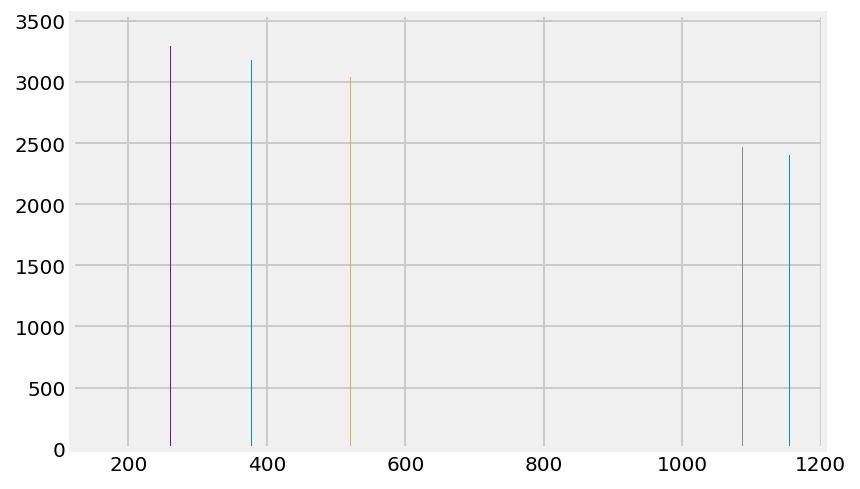

In [21]:
from collections import Counter

df_train_clean_y = df_train_clean.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)

classes = 0
for col in df_train_clean_y:
    print(col)
    counter = Counter(df_train_clean[col])
    for k,v in counter.items():
        if k == True:
            classes += 1
            per = v / len(df_train_clean[col]) * 100
            print('Class=%d, n=%d (%.3f%%)' % (classes, v, per))
            plt.bar(counter[True], counter.values())
        


Siendo un problema multietiqueta, el estudio del equilibrio entre clases es diferente, ya que no se trata de estudiar cuantos tuits tienen la misma etiqueta, sino que un mismo tuit puede tener varias etiquetas. Si estudiáramos las etiquetas de forma agrupada, tendríamos un gran problema de desequilibrio, ya que de algunos grupos de etiquetas habría muy pocas muestras o incluso solo una. En cualquier caso, el desequilibrio en el número de muestras de cada clase es también evidente, lo cual nos llevará a obtener muy malos resultados en nuestra clasificación, especialmente en las clases con menos muestras.

## Extracción de características y modelado del clasificador
Para afrontar la naturaleza multietiqueta del problema, en la categoría de ML usaremos la librería scikit-multilearn la cual está integrada en el ecosistema scikit-learn. Con la ayuda de esta librería entrenaremos 2 modelos de ML y compararemos sus resultados.

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import csv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

Lo primero que hacemos es dividir nuestro dataset de entrenamiento en dos particiones: train y validation. A continuación, convertimos los datos de texto en matrices TF-IDF llevando así a cabo la extracción de características. Añadiremos los n-gramas con una longitud máxima de 3 como posibles características.

In [23]:
train, val = train_test_split(df_train_clean, random_state=42, test_size=0.30, shuffle=True)
train_text = train['limpio'].values.astype('U')
val_text = val['limpio'].values.astype('U')

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(val_text)
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)
x_val = vectorizer.transform(val_text)
y_val = val.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)

## Clasificadores basados en técnicas de ML
<br>
Vamos a probar dos modelos distintos de ML para problemas de multietiqueta: <b>Label Powerset y Classifier Chain Model</b><br>
Evaluaremos los resultados usando las siguientes métricas:<br>
- Accuracy: nos muestra la precisión del modelo pero se ve ampliamente afectada cuando existe una gran cantidad de falsos positivos.<br>
- F1 score: recomendada en casos de distribuciones desbalanceadas, como es nuestro caso.<br>
- Hamming loss: indica la fracción de etiquetas que no se han predicho correctamente, lo cual aporta información adicional para los problemas con datasets desbalanceados como el nuestro.


### Label Powerset
Este enfoque mapea cada combinación de etiquetas como si fuera una sola etiqueta y entrena un solo clasificador. La parte buena es que tiene en cuenta la correlación entre etiquetas, pero sin embargo, requiere alta capacidad computacioinal y puede producir un gran desequilibrio entre clases debido a que algunas de ellas no tendrán apenas muestras.

In [24]:
#
lp_classifier = LabelPowerset(LogisticRegression())
lp_classifier.fit(x_train, y_train)
lp_predictions = lp_classifier.predict(x_val)
print("Accuracy = ",accuracy_score(y_val,lp_predictions))
print("F1 score = ",f1_score(y_val,lp_predictions, average="micro"))
print("Hamming loss = ",hamming_loss(y_val,lp_predictions))

Accuracy =  0.17586529466791395
F1 score =  0.33298574904414324
Hamming loss =  0.16319414916234373


### Classifier Chain
Este método aprende a clasificar como si fuera un método de clasificación binaria, sin embargo todos los clasificadores están conectados en una cadena. Al igual que el anterior este modelo también tiene en cuenta la correlación de etiquetas y en este caso, la carga computacional no es tan elevada. No obstante, la precisión depende mucho del orden en el que se predicen las etiquetas, de hecho este orden tiene un gran impacto en los resultados.<br>
<br>
Vamos a predecir la probabilidad de cada clase y después revisaremos el umbral (por defecto es 0.5). De esta forma distinguiremos entre 0/1 para llevar a cabo la asignación de la etiqueta. 

t = 0.05
Accuracy =  0.0
F1 =  0.2785199578981459
Hamming loss =  0.7578025342291012
t = 0.06
Accuracy =  0.0
F1 =  0.28870981717355515
Hamming loss =  0.6981035802364146
t = 0.07
Accuracy =  0.0
F1 =  0.30210000941708254
Hamming loss =  0.6302406667233609
t = 0.08
Accuracy =  0.0
F1 =  0.3172586188938652
Hamming loss =  0.557445361000085
t = 0.09
Accuracy =  0.0
F1 =  0.33151059466848937
Hamming loss =  0.499022025682456
t = 0.1
Accuracy =  0.0
F1 =  0.3470062446430757
Hamming loss =  0.4535249596054086
t = 0.11
Accuracy =  0.0
F1 =  0.36161879895561355
Hamming loss =  0.4158516880687133
t = 0.12
Accuracy =  0.0
F1 =  0.37506987143655673
Hamming loss =  0.3803044476571137
t = 0.13
Accuracy =  0.0
F1 =  0.38554216867469887
Hamming loss =  0.3513053831108087
t = 0.14
Accuracy =  0.0009354536950420954
F1 =  0.39549788963576676
Hamming loss =  0.32885449442979847
t = 0.15
Accuracy =  0.0037418147801683817
F1 =  0.399805131536213
Hamming loss =  0.31431244153414406
t = 0.16
Accuracy =  0.0

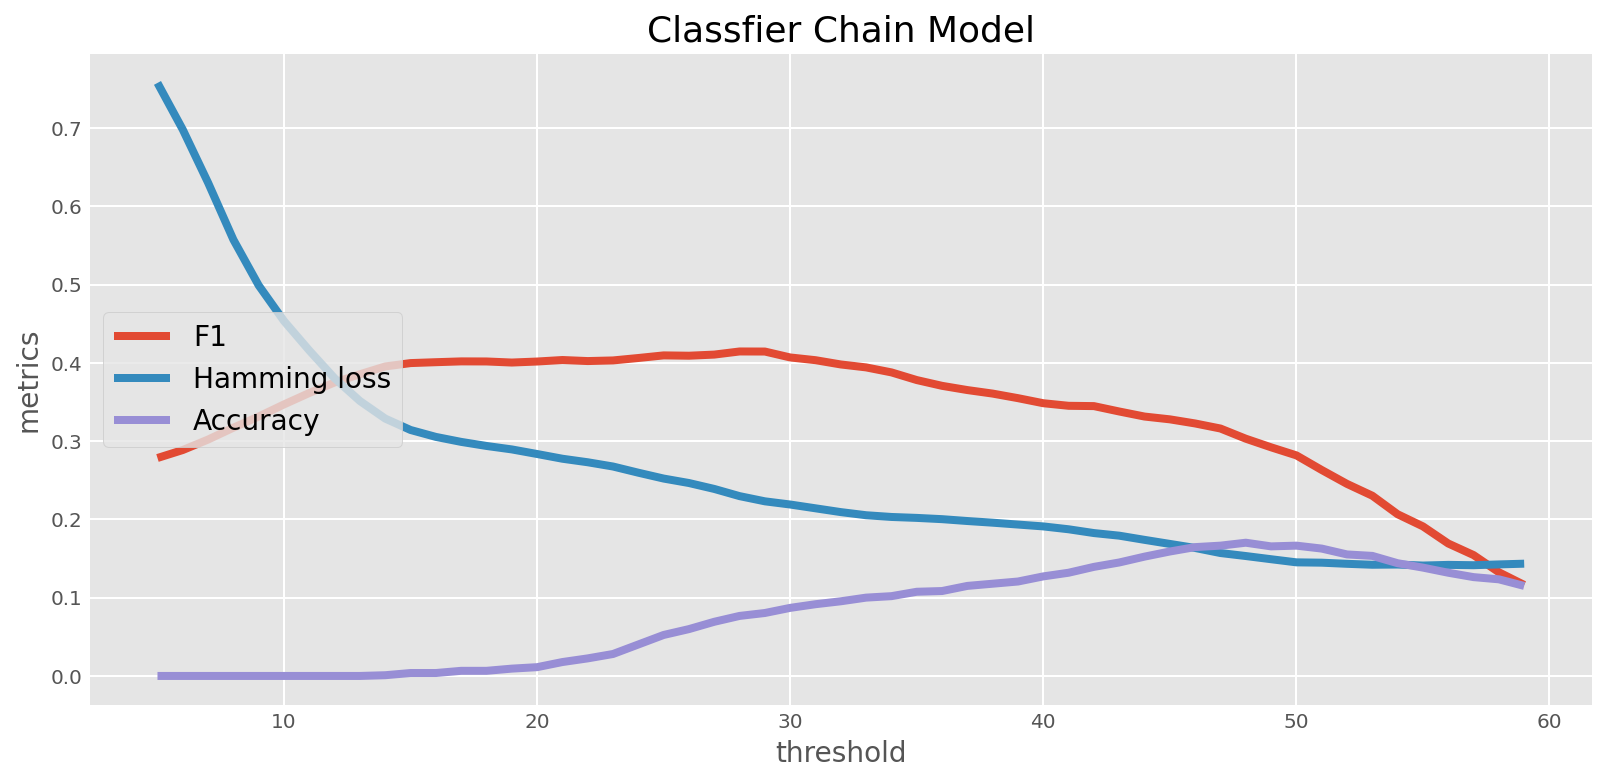

In [25]:
#for the next classifier we need to remove from y-train, y-val categories which equal 0 for all train samples
y_train = train.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)
selected_labels = y_train.columns[y_train.sum(axis = 0, skipna = True) > 0].tolist()
y_val = val.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)
y_train = y_train.filter(selected_labels, axis=1)
y_val = y_val.filter(selected_labels, axis=1)
x_train = vectorizer.transform(train_text)
x_val = vectorizer.transform(val_text)
cc_classifier = ClassifierChain(LogisticRegression(solver='newton-cg'))
cc_classifier.fit(x_train, y_train)
cc_predictions_proba = cc_classifier.predict_proba(x_val)
#for plotting metrics as a function of threashold
th = []
f = []
ham = []
ac = []
for t in range (5,60): # threshold value
    y_pred_new = (cc_predictions_proba >= t/100).astype(int)
    print("t =" ,t/100)
    print("Accuracy = ",accuracy_score(y_val,y_pred_new))
    print("F1 = ",f1_score(y_val,y_pred_new, average="micro"))
    print("Hamming loss = ",hamming_loss(y_val,y_pred_new))
    th.append(t)
    ac.append(accuracy_score(y_val,y_pred_new))
    f.append(f1_score(y_val,y_pred_new, average="micro"))
    ham.append(hamming_loss(y_val,y_pred_new))
    plt.rcParams["figure.figsize"] = (12,6)
with plt.style.context('ggplot'):
    plt.plot(th, f)
    plt.plot(th, ham)
    plt.plot(th, ac)
    plt.legend(['F1', 'Hamming loss', 'Accuracy'], loc='center left', fontsize = 14)
    plt.ylabel("metrics", fontsize = 14)
    plt.xlabel("threshold", fontsize = 14)
    plt.title("Classfier Chain Model", fontsize = 18)
plt.show()

El diagrama muestra que el punto óptimo del umbral es alrededor de 0.4, en ese punto el F1 score está cerca de su máximo 0.41, el accuracy es creciente y el Hamming loss decreciente.

Tras revisar las métricas de ambos modelos, podemos concluir que ambos han obtenido resultados bastante precarios, pero el modelo Classifier Chain obtiene unos resultados del F1 score ligeramente superiores por tanto concluiríamos que en caso de usar un modelo de ML, la mejor opción para este dataset sería el modelo Classifier Chain.

## Clasificadores basados en técnicas de DL

### Modelo RNN
Las redes recurrentes nos proporcionan información de los distintos elementos del documento de forma secuencial, permitiendo que nuestro modelo aprenda teniendo en cuenta parte del contexto.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
import re, string, spacy

In [27]:
#Definimos características de la capa RNN

RNN_DIM = 50 #Nº de neuronas en la capa RNN
RNN_layer = LSTM 

In [28]:
#Estimamos el tamaño de vocabulario (parabras con un min_df de 2 en TRAIN)
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=2)
cv.fit(train['limpio'])
max_features = len(cv.get_feature_names_out())
print('Tamaño vocabulario: {}'.format(max_features))

Tamaño vocabulario: 1711


In [29]:
#Definimos el espacio de características 
MAX_NB_WORDS = max_features+2 #hay que considerar 1 término más para el OOV y otro para el 0
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ', oov_token='OOV')
tokenizer.fit_on_texts(train['limpio'].values)
X_train = tokenizer.texts_to_sequences(train['limpio'].values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
MAX_SEQUENCE_LENGTH = X_train.shape[1]

X_val = tokenizer.texts_to_sequences(val['limpio'].values)
X_val = pad_sequences(X_val, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
# es posible añadir padding tanto al principio como al final de la secuencia
# Es recomendable usar el llamado "post-padding" (introducir padding al final)
# cuando trabajamos con redes LSTM, para así poder implementar la 
# CuDNN de las capas y conseguir un mejor aprovechamiento computacional).

Found 5398 unique tokens.


In [30]:
#Definimos las etiquetas
y_train = train.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)
y_train_true = (y_train == True).values*1
y_val = val.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)
y_val_true = (y_val == True).values*1

In [31]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(2492, 22) (2492, 11)
(1069, 22) (1069, 11)


In [32]:
MAX_NB_WORDS

1713

In [33]:
#Rellenamos los vectores con el valor en spaCy para la MAX_NB_WORDS palabras más frecuentes
nlp=spacy.load('es_core_news_md')


EMBEDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBEDDING_DIM))
vectores = 0
for word, i in word_index.items():
    if(i<MAX_NB_WORDS):
        embedding_vector = nlp.vocab[word].vector
        if not np.array_equal(embedding_vector, np.zeros(EMBEDDING_DIM)):
            # las palabras que no se encuentre en el índice de los embeddings serán todo ceros.
            embedding_matrix[i] = embedding_vector
            vectores += 1
        
print("Cargados {} vectores en la matriz".format(vectores))

Cargados 1634 vectores en la matriz


In [34]:
embedding_matrix.shape

(1713, 300)

In [35]:
#Creamos el modelo RNN en Keras usando los embeddings cargados como pesos
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False,
                            mask_zero=True)

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.4))
model.add(LSTM(RNN_DIM, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)) #no usamos recurrent_dropout=0.2 por problemas con el M1
model.add(LSTM(RNN_DIM, dropout=0.2, recurrent_dropout=0.2)) #no usamos recurrent_dropout=0.2 por problemas con el M1
model.add(Dense(11, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 300)           513900    
                                                                 
 spatial_dropout1d (SpatialD  (None, 22, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 22, 50)            70200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 11)                561       
                                                                 
Total params: 604,861
Trainable params: 90,961
Non-trainable params: 513,900
_____________________________________________

In [36]:
#Aplicamos el modelo a nuestros datos de train y validation
batch_size=16
history=model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val))

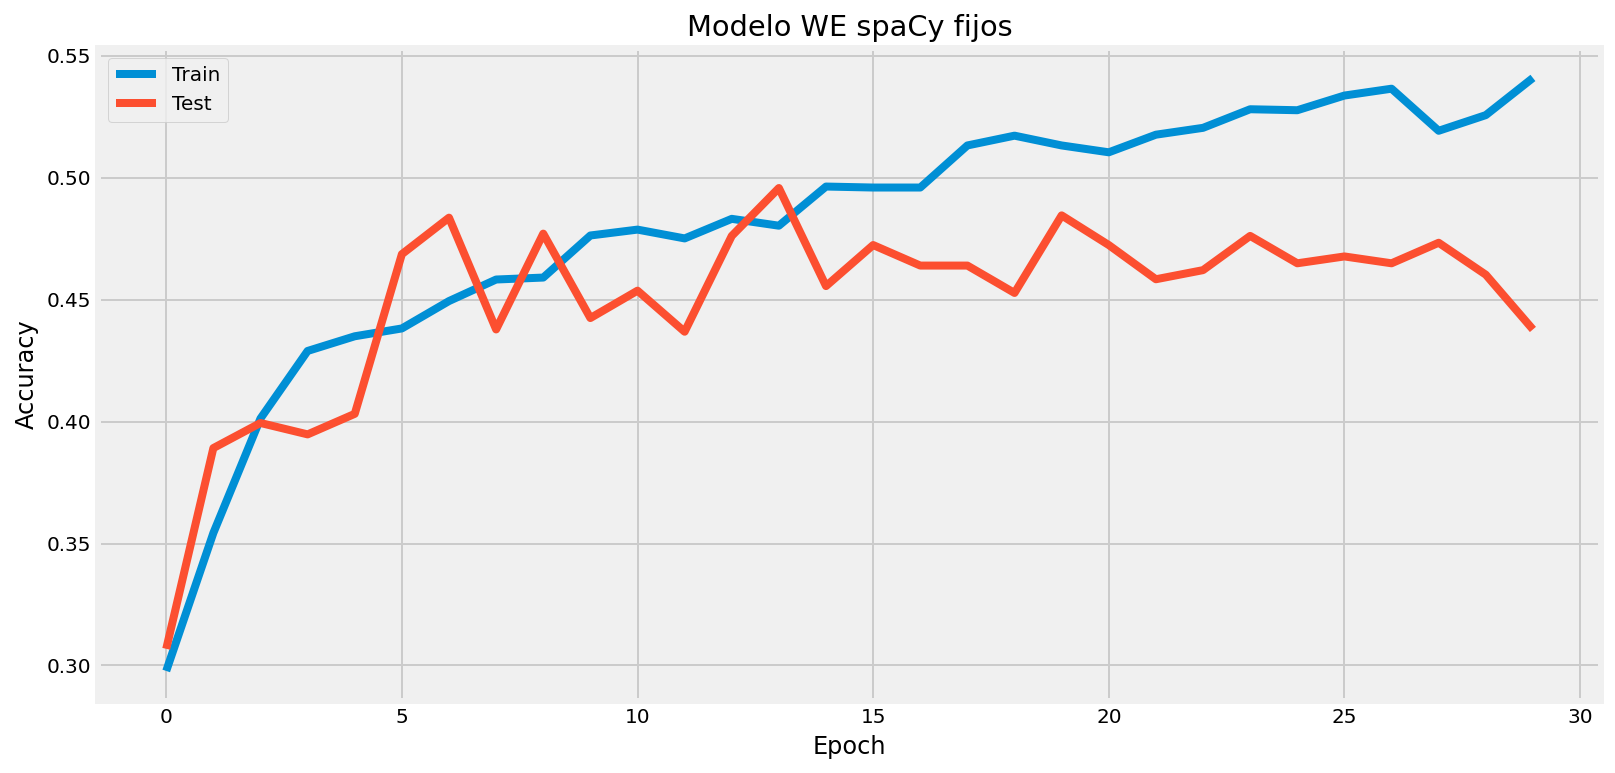

In [37]:
# Comprobamos las métricas de nuestro modelo en fase de entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo WE spaCy fijos')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [38]:
#Llevamos a cabo la evaluación de nuestro modelo antes de llevarlo a inferencia
score,acc = model.evaluate(X_val, y_val, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

67/67 - 1s - loss: 0.3497 - accuracy: 0.4378 - 611ms/epoch - 9ms/step
score: 0.35
acc: 0.44


In [39]:
#Revisamos las métricas
predict=model.predict(X_val, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report

print(classification_report(y_val, prediccion, target_names=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'], zero_division=0))

1069/1069 [==============================] - 8s 6ms/step
              precision    recall  f1-score   support

       anger       0.62      0.47      0.53       348
anticipation       0.33      0.02      0.05       124
     disgust       0.35      0.15      0.21       147
        fear       0.61      0.49      0.54       108
         joy       0.66      0.59      0.62       325
        love       0.64      0.30      0.40        71
    optimism       0.50      0.08      0.14       115
   pessimism       0.57      0.16      0.25       180
     sadness       0.69      0.45      0.55       240
    surprise       0.00      0.00      0.00        56
       trust       0.00      0.00      0.00        60

   micro avg       0.62      0.34      0.44      1774
   macro avg       0.45      0.25      0.30      1774
weighted avg       0.54      0.34      0.40      1774
 samples avg       0.45      0.35      0.38      1774



Las métricas nos muestran que hay un gran desequilibrio entre las diferentes etiquetas algunas consiguen una gran precisión como en el caso del miedo (fear) o la tristeza (sadness), probablemente debido a que nuestro dataset contenía una cantidad de datos mayor que estaban etiquetados con estos sentimientos. Observamos que tanto la sorpresa (surprise) como la confianza (trust) obtienen una precisión de 0 y al comprobar la cantidad de datos de nuestro dataset con estas etiquetas vemos que ambos sentimientos contaban con la representación más baja del conjunto de etiquetas dentro de nuestro dataset. Además, el F1 score se situa más o menos en el mismo nivel que en los modelos de ML alrededor de 0.4.

### Modelo BERT
BERT es una biblioteca de código abierto creada por Google en 2018 basada en la arquitectura de Transformer. A diferencia de la mayoría de las técnicas, el modelo Bert analiza los documentos en ambas direcciones lo cual le proporciona mayor información.
En este caso haremos transfer learning y usaremos un modelo BERT pre-entrenado. Durante la configuración del modelo modificaremos las últimas capas para adaptar el modelo a nuestro problema de clasificación multietiqueta.

In [50]:
from transformers import TFBertModel
from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [51]:
#modelo a utilizar
nombre_modelo = 'bert-base-multilingual-uncased'

### Preparamos los datos para poder proporcionárselos al modelo
Fijamos un tamaño máximo de vocabulario.  
Separamos los tweets en tokens dentro de este vocabulario y creamos las secuencias de longitud fija.  
La longitud de la secuencia viene dada por la longitud en tokens del tweet más largo. Sólo se conservan los tokens de las palabras en el vocabulario.

In [52]:
type(df_train_clean)

pandas.core.frame.DataFrame

In [56]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3561 entries, 0 to 3560
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             3561 non-null   object
 1   Tweet          3561 non-null   object
 2   anger          3561 non-null   bool  
 3   anticipation   3561 non-null   bool  
 4   disgust        3561 non-null   bool  
 5   fear           3561 non-null   bool  
 6   joy            3561 non-null   bool  
 7   love           3561 non-null   bool  
 8   optimism       3561 non-null   bool  
 9   pessimism      3561 non-null   bool  
 10  sadness        3561 non-null   bool  
 11  surprise       3561 non-null   bool  
 12  trust          3561 non-null   bool  
 13  pre_clean_len  3561 non-null   int64 
 14  limpio         3561 non-null   object
dtypes: bool(11), int64(1), object(3)
memory usage: 306.4+ KB


In [91]:
#Definimos las etiquetas
Y = df_train_clean.drop(labels = ['pre_clean_len', 'limpio', 'ID', 'Tweet'], axis=1)

In [66]:
X = df_train_clean['limpio']

In [92]:
#Separamos entrenamiento y test para este nuevo modelo
X_train_tweets, X_test_tweets, Y_train, Y_val = train_test_split(X, Y, random_state=42, test_size=0.30)
print(X_train_tweets.shape,Y_train.shape)
print(X_test_tweets.shape,Y_test.shape)

(2492,) (2492, 11)
(1069,) (1069, 11)


In [93]:
#Estimamos la longitud máxima de documento
MAX_SEQUENCE_LENGTH=np.max([len(l.split()) for l in X_train_tweets]) #limitamos longitud al cuantil 99%
print('longitud máxima: {}'.format(MAX_SEQUENCE_LENGTH))

longitud máxima: 22


Los modelos de `transformers` utilizan 3 vectores para cada entrada:  
 - 'input_ids': ID del vocabulario para hacer un embedding de los tokens  
 - 'token_type_ids': ID de la frase (en aplicaciones con 2 frases de entrada)
 - 'attention_mask': máscara de atención de los tokens  
Usamos una función de tokenizado específica del modelo para obtener estos vectores

In [94]:
type(X_train_tweets)

pandas.core.series.Series

In [114]:
#Tokenizamos y codificamos como Dataset
tokenizer_transf = BertTokenizer.from_pretrained(nombre_modelo)
train_encodings = tokenizer_transf(X_train_tweets.to_list(), truncation=True, padding=True, return_tensors="tf")

In [96]:
train_encodings['input_ids'].shape

TensorShape([2492, 42])

La longitud máxima es mayor que la estimada (por el tokenizado *WordPiece*)

In [137]:
MAX_SEQUENCE_LENGTH=train_encodings['input_ids'].shape[1]
val_encodings = tokenizer_transf(X_test_tweets.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

In [98]:
val_encodings['input_ids'].shape

TensorShape([1069, 42])

In [99]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

Tomamos un ejemplo para comprobar que se han creado cada uno de los 3 vectores.

In [100]:
X_train_tweets.to_list()[0]

'mencion buena noche donde podria levantar uno queja uno equipaje dañado que querer pagar mencion tener todo prueba'

In [101]:
train_encodings['input_ids'][0]

<tf.Tensor: shape=(42,), dtype=int32, numpy=
array([  101, 76269, 28546, 25605, 12011, 23254, 83668, 10370, 11446,
       10126, 10295, 11446, 30603, 20515, 16703, 10351, 10126, 50292,
       10177, 38815, 76269, 18959, 12692, 32473,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0])>

In [102]:
train_encodings['attention_mask'][0]

<tf.Tensor: shape=(42,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [103]:
print(tokenizer_transf.convert_ids_to_tokens(train_encodings['input_ids'][0]))

['[CLS]', 'mencion', 'buena', 'noche', 'donde', 'podria', 'levant', '##ar', 'uno', 'que', '##ja', 'uno', 'equip', '##aje', 'dana', '##do', 'que', 'quer', '##er', 'pagar', 'mencion', 'tener', 'todo', 'prueba', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [104]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    Y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    Y_val
))

In [105]:
train_dataset

<TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(42,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(42,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(42,), dtype=tf.int32, name=None)}, TensorSpec(shape=(11,), dtype=tf.bool, name=None))>

In [ ]:
## Personalización del modelo Bert para nuestro problema de clasificación
A continuación usaremos la librería de Keras para ajustar nuestro modelo Bert al problema de clasificación multietiqueta en el que estamos trabajando.<br>
Usamos la primera capa del modelo y ajustamos la salida para que calcule la probabilidad de nuestras 11 etiquetas. Es posible añadir más capas ocultas entre la salida del encoder y la capa de salida para intentar afinar el modelo y conseguir mejores resultados.  
  
Replicamos el modelo que utiliza TFBertForSequenceClassification:  
 - Después del pooler_output hacemos un dropout para generar los logits.  
 - Los logits entran a una capa densa con activación sigmoide para ajustarla a nuestro clasificador.  

Los parámetros de la última capa vienen dados por el nº de etiquetas (una neurona por etiqueta) con una entrada de 768 dimensiones (embedding del token `[CLS]' de cada muestra)
<br>
<br>
Ajustamos la capa de salida de forma que se ajuste a nuestro problema multietiqueta (11 etiquetas = 11 neuronas) y elegimos un tipo de activación sigmoide recomendado para problemas multietiqueta.

In [107]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from transformers import TFBertModel

#######################################
### --------- Setup BERT ---------- ###


# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(nombre_modelo)
config.output_hidden_states = False

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(nombre_modelo, config = config)

#######################################
### ------- Build the model ------- ###
# TF Keras documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

# Build your model input
input_ids = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(MAX_SEQUENCE_LENGTH,), name='attention_mask', dtype='int32') 
# Load the Transformers BERT model as a layer in a Keras model
pooled_output = transformer_model(input_ids, attention_mask)[1]  # (bs, dim)
pooled_output = Dropout(0.1)(pooled_output)  # (bs, dim)
# Then build your model output
output = Dense(units=11,
               kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
               activation="sigmoid",
               name='clases')(pooled_output)
# And combine it all in a model object
model = Model(inputs=[input_ids, attention_mask], outputs=output, name='BERT_BinaryClass')
# Take a look at the model
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "BERT_BinaryClass"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 42)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  167356416   ['input_ids[0][0]',              
                                thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 42,                                               
                                 768),                                             

In [108]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-08)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
batch_size=8
history=model.fit(train_dataset.batch(batch_size), epochs=10, batch_size=batch_size, validation_data=val_dataset.batch(batch_size))

Epoch 1/10


C:\Users\Mari\anaconda3\envs\Neni_fixed\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


312/312 [==============================] - 1054s 3s/step - loss: 0.4235 - accuracy: 0.3222 - val_loss: 0.3854 - val_accuracy: 0.4453
Epoch 2/10
312/312 [==============================] - 1191s 4s/step - loss: 0.3662 - accuracy: 0.4795 - val_loss: 0.3510 - val_accuracy: 0.5210
Epoch 3/10
312/312 [==============================] - 1189s 4s/step - loss: 0.3233 - accuracy: 0.5405 - val_loss: 0.3327 - val_accuracy: 0.5435
Epoch 4/10
312/312 [==============================] - 1240s 4s/step - loss: 0.2868 - accuracy: 0.5899 - val_loss: 0.3237 - val_accuracy: 0.5360
Epoch 5/10
312/312 [==============================] - 1229s 4s/step - loss: 0.2578 - accuracy: 0.6268 - val_loss: 0.3255 - val_accuracy: 0.5463
Epoch 6/10
312/312 [==============================] - 1196s 4s/step - loss: 0.2357 - accuracy: 0.6461 - val_loss: 0.3319 - val_accuracy: 0.5351
Epoch 7/10
312/312 [==============================] - 1243s 4s/step - loss: 0.2143 - accuracy: 0.6657 - val_loss: 0.3336 - val_accuracy: 0.5500
Epo

KeyboardInterrupt: 

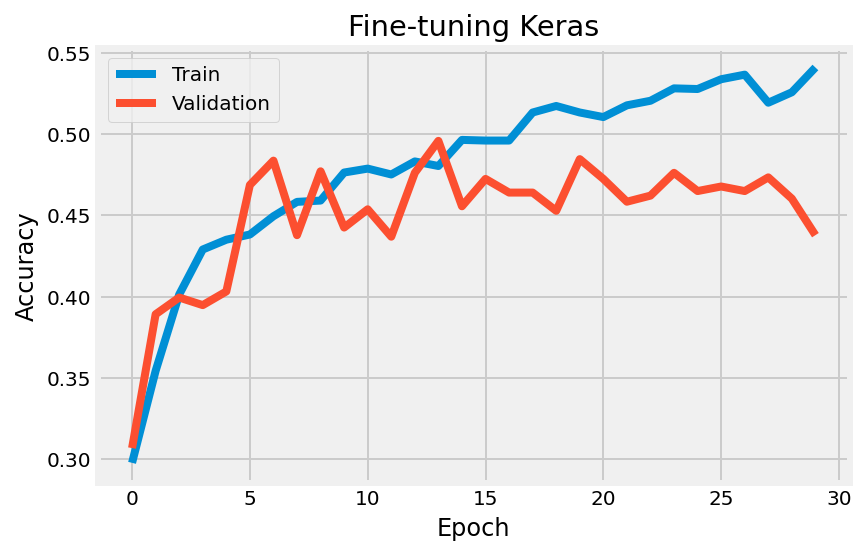

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fine-tuning Keras')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [122]:
predict = model.predict(val_dataset.batch(batch_size))
predict_clases = (predict>0.5).tolist()
from sklearn.metrics import classification_report

print(classification_report(Y_val, predict_clases, target_names=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'], zero_division=0))

134/134 [==============================] - 93s 694ms/step
              precision    recall  f1-score   support

       anger       0.70      0.61      0.65       348
anticipation       0.29      0.32      0.31       124
     disgust       0.41      0.37      0.39       147
        fear       0.62      0.63      0.62       108
         joy       0.70      0.70      0.70       325
        love       0.72      0.32      0.45        71
    optimism       0.29      0.30      0.29       115
   pessimism       0.49      0.25      0.33       180
     sadness       0.76      0.42      0.54       240
    surprise       0.00      0.00      0.00        56
       trust       0.67      0.07      0.12        60

   micro avg       0.58      0.45      0.51      1774
   macro avg       0.51      0.36      0.40      1774
weighted avg       0.58      0.45      0.49      1774
 samples avg       0.55      0.48      0.48      1774



Tras el entrenamiento de nuestro modelo BERT tuneado vemos que, aunque poco, sí hemos conseguido un F1 score mayor al que habíamos conseguido hasta ahora 0.49. Además los resultados individuales por etiqueta también mejoran, por lo tanto, podemos concluir que este es el modelo que mejores resultados nos ha dado y por ese motivo es el modelo que llevaremos a inferencia.

## Inferencia
Es el momento de proner a prueba nuestro modelo con nuestro conjunto de test compuesto por datos que no ha visto nunca durante el entrenamiento.

In [131]:
#Creamos un dataframe vacio que llenaremos con los resultados que obtengamos
df_test_transf = pd.DataFrame(columns=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'], index=None)
df_test_transf

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust


In [132]:
#Iteramos sobre el conjunto de test para obtener las probabilidades de cada etiqueta
#y vamos rellenando nuestro dataframe
for twt in df_test_clean['Tweet']:
    tuit_encodings= tokenizer_transf([clean_text(twt, lemas=True)], truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")
    test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(tuit_encodings)))
    predict_transf = model.predict(test_dataset.batch(batch_size))
    df_transf = pd.DataFrame(predict_transf, columns=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])
    df_test_transf = df_test_transf.append(df_transf)

1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 169ms/step


In [133]:
df_test_transf

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,0.074486,0.598690,0.031398,0.032601,0.042821,0.013226,0.096093,0.113453,0.033164,0.092595,0.056260
0,0.024561,0.685346,0.027756,0.761937,0.060921,0.024974,0.069867,0.195024,0.077027,0.233716,0.077132
0,0.223577,0.023344,0.164800,0.007995,0.866287,0.009905,0.048484,0.249730,0.029689,0.019358,0.018193
0,0.855251,0.130594,0.355939,0.121438,0.035181,0.031249,0.063823,0.021721,0.012554,0.057731,0.076906
0,0.919511,0.009208,0.668902,0.026127,0.067420,0.015442,0.012956,0.101244,0.258121,0.018322,0.014412
...,...,...,...,...,...,...,...,...,...,...,...
0,0.196367,0.326021,0.222408,0.774620,0.311380,0.057771,0.074106,0.068661,0.011928,0.306381,0.228492
0,0.028176,0.434821,0.028803,0.011104,0.741200,0.047685,0.686097,0.098342,0.013536,0.059455,0.166309
0,0.017730,0.042655,0.017160,0.018222,0.987937,0.116938,0.194948,0.024933,0.018764,0.025281,0.034329
0,0.854026,0.040857,0.670052,0.204215,0.013134,0.007814,0.008314,0.097714,0.052448,0.044105,0.019731


In [134]:
#Establecemos el criterio de True/False para que todos aquellos resultados
#mayores o iguales al 50% sean True y el resto False
for i in df_test_transf:
    print(type(df_test_transf[i]))
    df_test_transf.loc[df_test_transf[i] >= 0.5, i] = True
    df_test_transf.loc[df_test_transf[i] <= 0.5, i] = False

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [135]:
#Modificamos el índice de nuestro dataframe para que sea correlativo
extract_col = df_train_clean['ID']
df_test_transf.insert(0, 'ID', extract_col)
df_test_transf = df_test_transf.reset_index(drop=True)
df_test_transf

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,False,True,False,False,False,False,False,False,False,False,False
1,2018-Es-01643,False,True,False,True,False,False,False,False,False,False,False
2,2018-Es-01643,False,False,False,False,True,False,False,False,False,False,False
3,2018-Es-01643,True,False,False,False,False,False,False,False,False,False,False
4,2018-Es-01643,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
674,2018-Es-01643,False,False,False,True,False,False,False,False,False,False,False
675,2018-Es-01643,False,False,False,False,True,False,True,False,False,False,False
676,2018-Es-01643,False,False,False,False,True,False,False,False,False,False,False
677,2018-Es-01643,True,False,True,False,False,False,False,False,False,False,False


In [136]:
#Creamos el archivo .csv con nuestros resultados
import os  

os.makedirs('C:/Users/Mari/Desktop/Master_IA/NLP/Ejer_eval_NLP/Delivery', exist_ok=True)  

df_test_transf.to_csv('C:/Users/Mari/Desktop/Master_IA/NLP/Ejer_eval_NLP/Delivery/soluciones_m_angeles_garcia_escriva.csv')